##Описание работы

###Цель работы

Изучение логических и метрических методов машинного обучения. Изучение влияния разных гиперпараметров на поведение алгоритма и качество его работы. Сравнение разных методов между собой и выявление лучшего для конкретной задачи на конкретном датасете

###Выборка данных (датасет)

* Ссылка на выборку: https://www.kaggle.com/iabhishekofficial/mobile-price-classification/metadata
* Описание выборки: Выборка содержит признаковое описание телефонов и их ценовой диапазон
* Количество классов: 4
* Отношение классов: 25% 25% 25% 25%
* Количество признаков: 20
* Количество объектов: 2000

## Библиотеки

Установка библиотеки для визуализации

In [ ]:
!pip install umap-learn update

     |████████████████████████████████| 86 kB 4.0 MB/s 
     |████████████████████████████████| 1.1 MB 61.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=7590268786e4bd37b3b260dccc8d3463ecd188fa92adc84d8cc4e3aeef9eba9a
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=ffd0db93f6f4ad9b909196cff5bed3d0c3d40dbdb164fa42015c16885726f82e
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


Подключаем необходимые библиотеки

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import softmax
from scipy.spatial.distance import cdist
import numpy as np
import torch

from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier, KernelDensity

from mlxtend.plotting import plot_decision_regions
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from pprint import pprint

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Подключение выборки данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/ML Lessons/train.csv')

In [ ]:
print(train.shape)
train.head()

(2000, 21)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


In [ ]:
y, X = train['price_range'], train.drop(['price_range'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, 
                                                    random_state=42, shuffle=True, stratify=y)

## Визуализация

Визуализация частоты классов датасете

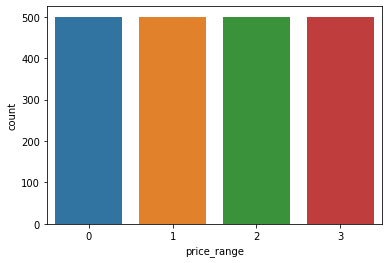

In [ ]:
sns.countplot(train['price_range'])

In [ ]:
import umap

umap = umap.UMAP(n_neighbors=9, min_dist=0.7)
transformed_features = umap.fit_transform(X_train)

In [ ]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

Визуализация данных с помощью алгоритма понижения размерности u-map

In [ ]:
draw_vectors(
    transformed_features[:, 0], 
    transformed_features[:, 1], 
    color=[["red", "blue", "green", "yellow"][t] for t in y_train]
    )

Figure(id='1003', ...)

Выборка линейно разделима в пространстве рамерности 2, это означает, что задача решится с высокой точностью с помощью метрических методов

## Feature Impotance

Best alpha using built-in LassoCV: 1.111885
Best score using built-in LassoCV: 0.917179
Lasso picked 5 variables and eliminated the other 15 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

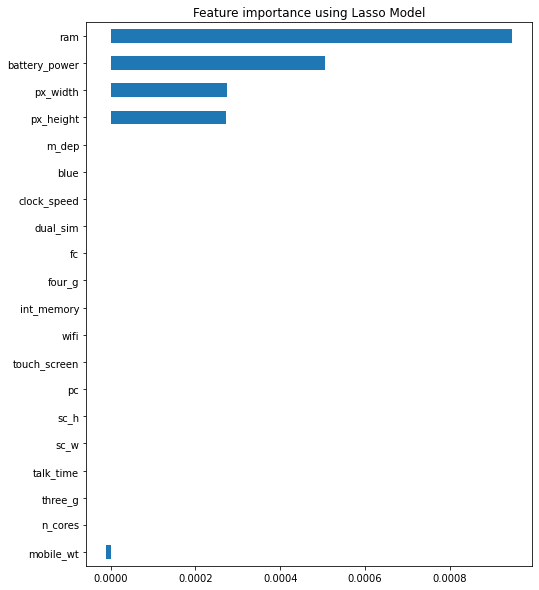

In [ ]:
from sklearn.linear_model import LassoCV
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

График показывает, что из 20 признаков можно оставить только 5 без существенной потери качества

# Метрические методы

## K-Neighbors Classifier

In [ ]:
print('K\t', 'Обучение\t', 'Контроль');

kneighbors_models = []
for n_neighbors in range(1, 20):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    kneighbors_models.append(model)
    print('{} \t {:1.4f} \t {:1.4f}'.format(n_neighbors, f1_score(model.predict(X_train), y_train, average='macro'), 
                                            f1_score(model.predict(X_test), y_test, average='macro'), end='\n'))

K	 Обучение	 Контроль
1 	 1.0000 	 0.9091
2 	 0.9448 	 0.9014
3 	 0.9529 	 0.9272
4 	 0.9351 	 0.9059
5 	 0.9434 	 0.9243
6 	 0.9395 	 0.9137
7 	 0.9493 	 0.9274
8 	 0.9411 	 0.9211
9 	 0.9516 	 0.9303
10 	 0.9478 	 0.9274
11 	 0.9501 	 0.9274
12 	 0.9367 	 0.9290
13 	 0.9457 	 0.9275
14 	 0.9418 	 0.9229
15 	 0.9403 	 0.9213
16 	 0.9418 	 0.9230
17 	 0.9410 	 0.9259
18 	 0.9389 	 0.9290
19 	 0.9441 	 0.9290


## Radius Neighbors Classifier

In [ ]:
print('Radius\t', 'Обучение\t', 'Контроль');

radiusneighbors_models = []
for radius in range(510, 530):
      model = RadiusNeighborsClassifier(radius=radius, outlier_label=-1)
      model.fit(X_train, y_train)
      radiusneighbors_models.append(model)
      print('{} \t {:1.4f} \t {:1.4f}'.format(radius, f1_score(model.predict(X_train), y_train, average='macro'), 
                                            f1_score(model.predict(X_test), y_test, average='macro'), end='\n'))

Radius	 Обучение	 Контроль
510 	 0.9313 	 0.9274
511 	 0.9306 	 0.9289
512 	 0.9321 	 0.9289
513 	 0.9336 	 0.9289
514 	 0.9359 	 0.9274
515 	 0.9351 	 0.9289
516 	 0.9344 	 0.9305
517 	 0.9336 	 0.9305
518 	 0.9351 	 0.9305
519 	 0.9358 	 0.9305
520 	 0.9351 	 0.9289
521 	 0.9358 	 0.9275
522 	 0.9366 	 0.9244
523 	 0.9366 	 0.9260
524 	 0.9351 	 0.9245
525 	 0.9337 	 0.9245
526 	 0.9352 	 0.9245
527 	 0.9352 	 0.9244
528 	 0.9322 	 0.9214
529 	 0.9315 	 0.9229


## Kernel Density Classifier

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin


class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [ ]:
print('Wight\t', 'Обучение\t', 'Контроль');

kde_models = []
for width in range(190, 210):
      model = KDEClassifier(bandwidth=width)
      model.fit(X_train, y_train)
      kde_models.append(model)
      print('{} \t {:1.4f} \t {:1.4f}'.format(width, f1_score(model.predict(X_train), y_train, average='macro'), 
                                            f1_score(model.predict(X_test), y_test, average='macro'), end='\n'))

Wight	 Обучение	 Контроль
190 	 0.9732 	 0.9409
191 	 0.9732 	 0.9394
192 	 0.9724 	 0.9394
193 	 0.9724 	 0.9394
194 	 0.9724 	 0.9394
195 	 0.9724 	 0.9409
196 	 0.9717 	 0.9409
197 	 0.9709 	 0.9409
198 	 0.9709 	 0.9409
199 	 0.9694 	 0.9424
200 	 0.9694 	 0.9424
201 	 0.9687 	 0.9424
202 	 0.9687 	 0.9424
203 	 0.9672 	 0.9424
204 	 0.9672 	 0.9424
205 	 0.9672 	 0.9424
206 	 0.9664 	 0.9424
207 	 0.9664 	 0.9424
208 	 0.9657 	 0.9424
209 	 0.9649 	 0.9424


# Логические методы

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from mlxtend.plotting import plot_decision_regions
from matplotlib import gridspec
from sklearn import tree
from sklearn.decomposition import PCA

## Desicion Tree

In [ ]:
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [5, 6, 7, 8, 9, 10]}

print('Criterion, max_depth\t', 'Обучение\t', 'Контроль')

dtc_models = []
for params in list(ParameterGrid(param_grid)):
      model = DecisionTreeClassifier(random_state=123, class_weight='balanced', criterion=params['criterion'], max_depth=params['max_depth'])
      model.fit(X_train, y_train)
      dtc_models.append(model)
      print('{} \t\t {:1.4f} \t {:1.4f}'.format(str(params['criterion']) + ', ' + str(params['max_depth']), f1_score(model.predict(X_train), y_train, average='macro'), 
                                            f1_score(model.predict(X_test), y_test, average='macro'), end='\n'))

Criterion, max_depth	 Обучение	 Контроль
gini, 5 		 0.8930 	 0.8064
gini, 6 		 0.9148 	 0.8161
gini, 7 		 0.9524 	 0.8322
gini, 8 		 0.9755 	 0.8281
gini, 9 		 0.9896 	 0.8153
gini, 10 		 0.9948 	 0.8157
entropy, 5 		 0.8708 	 0.8141
entropy, 6 		 0.9282 	 0.8316
entropy, 7 		 0.9613 	 0.8410
entropy, 8 		 0.9858 	 0.8546
entropy, 9 		 0.9970 	 0.8576
entropy, 10 		 1.0000 	 0.8574


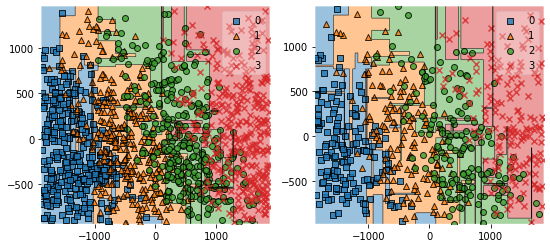

In [ ]:
model = DecisionTreeClassifier(random_state=123, class_weight='balanced', criterion='entropy', max_depth=9)
pca = PCA(n_components = 2)
X_train2 = pca.fit_transform(X_train)
X_test2 = pca.transform(X_test)
model.fit(X_train2, y_train)

fig, gs = plt.figure(figsize=(9,4)), gridspec.GridSpec(1, 2)

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))

plot_decision_regions(X_train2, y_train.to_numpy(), model, ax=ax[0])
plot_decision_regions(X_test2, y_test.to_numpy(), model, ax=ax[1])

plt.show()

In [ ]:
# Текстовое представление дерева

text_representation = tree.export_text(dtc_models[-2])
print(text_representation)

|--- feature_13 <= 2217.50
|   |--- feature_13 <= 1180.50
|   |   |--- feature_12 <= 1595.50
|   |   |   |--- feature_0 <= 1534.50
|   |   |   |   |--- class: 0
|   |   |   |--- feature_0 >  1534.50
|   |   |   |   |--- feature_13 <= 772.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_13 >  772.00
|   |   |   |   |   |--- feature_11 <= 416.00
|   |   |   |   |   |   |--- feature_15 <= 1.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_15 >  1.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_11 >  416.00
|   |   |   |   |   |   |--- feature_16 <= 19.50
|   |   |   |   |   |   |   |--- feature_12 <= 863.00
|   |   |   |   |   |   |   |   |--- feature_14 <= 16.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- feature_14 >  16.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- feature_12 >  863.00
|   |   |   |   |   |   |   |   |--- cla

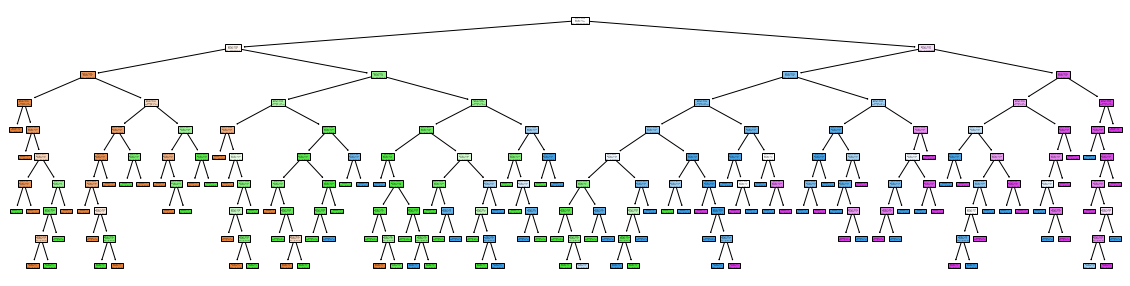

In [ ]:
# Графическое представление дерева

fig = plt.figure(figsize=(20,5))
_ = tree.plot_tree(dtc_models[-2], filled=True)

In [ ]:
# Зависимость результата от глубины дерева

models = []
for depth in range(5, 10):
    model = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', max_depth=depth, random_state=123)
    model.fit(X_train2, y_train)
    models.append(model)

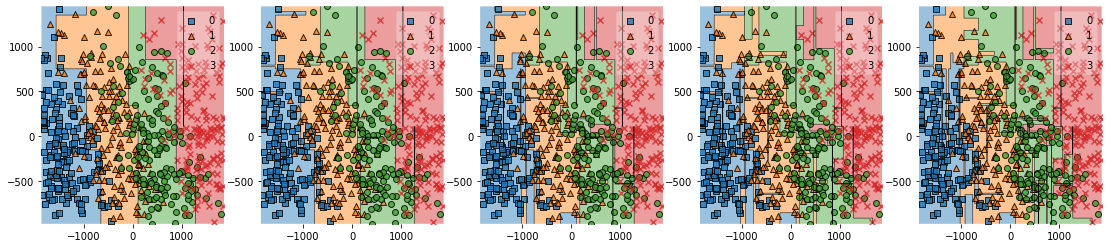

In [ ]:
fig, gs = plt.figure(figsize=(19, 4)), gridspec.GridSpec(1, 5)

ax = []
for i in range(5):
    ax.append(fig.add_subplot(gs[i]))

for i, model in enumerate(models):
    plot_decision_regions(X_test2, y_test.to_numpy(), model, ax=ax[i])

plt.show()

## Random Forest

In [ ]:
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [5, 6, 7, 8, 9, 10], 'max_features': ['auto', 'sqrt', 'log2', 13], 'n_estimators': [3, 5, 10, 50, 100]}

print('Criterion, max_depth, max_features, n_estimators\t', 'Обучение\t', 'Контроль');

rfc_models = []
for params in list(ParameterGrid(param_grid)):
      model = RandomForestClassifier(random_state=123, class_weight='balanced', criterion=params['criterion'], 
                                     max_depth=params['max_depth'], max_features=params['max_features'],
                                     n_estimators=params['n_estimators'])
      model.fit(X_train, y_train)
      rfc_models.append(model)
      print('{} \t\t\t\t\t {:1.4f} \t {:1.4f}'.format(str(params['criterion']) + ', ' + str(params['max_depth']) + ', ' + 
                                                str(params['max_features'])+ ', ' + str(params['n_estimators']), 
                                            f1_score(model.predict(X_train), y_train, average='macro'), 
                                            f1_score(model.predict(X_test), y_test, average='macro'), end='\n'))

Criterion, max_depth, max_features, n_estimators	 Обучение	 Контроль
gini, 5, auto, 3 					 0.8310 	 0.7547
gini, 5, auto, 5 					 0.8513 	 0.7615
gini, 5, auto, 10 					 0.8737 	 0.7783
gini, 5, auto, 50 					 0.9158 	 0.8177
gini, 5, auto, 100 					 0.9129 	 0.8116
gini, 5, sqrt, 3 					 0.8310 	 0.7547
gini, 5, sqrt, 5 					 0.8513 	 0.7615
gini, 5, sqrt, 10 					 0.8737 	 0.7783
gini, 5, sqrt, 50 					 0.9158 	 0.8177
gini, 5, sqrt, 100 					 0.9129 	 0.8116
gini, 5, log2, 3 					 0.8310 	 0.7547
gini, 5, log2, 5 					 0.8513 	 0.7615
gini, 5, log2, 10 					 0.8737 	 0.7783
gini, 5, log2, 50 					 0.9158 	 0.8177
gini, 5, log2, 100 					 0.9129 	 0.8116
gini, 5, 13, 3 					 0.8971 	 0.8702
gini, 5, 13, 5 					 0.9032 	 0.8599
gini, 5, 13, 10 					 0.9030 	 0.8543
gini, 5, 13, 50 					 0.9152 	 0.8657
gini, 5, 13, 100 					 0.9129 	 0.8582
gini, 6, auto, 3 					 0.8667 	 0.7634
gini, 6, auto, 5 					 0.8802 	 0.7852
gini, 6, auto, 10 					 0.9125 	 0.7738
gini, 6, auto, 50 					 0.9

In [ ]:
# Зависимость результата от количества деревьев

models = []
scores_train = []
scores_test = []
n_estimators = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for estimators in n_estimators:
    model = RandomForestClassifier(random_state=123, class_weight='balanced', criterion='gini', 
                                     max_depth=10, max_features='auto',
                                     n_estimators=estimators)
    model.fit(X_train, y_train)
    models.append(model)
    scores_test.append(model.score(X_test, y_test))
    scores_train.append(model.score(X_train, y_train))

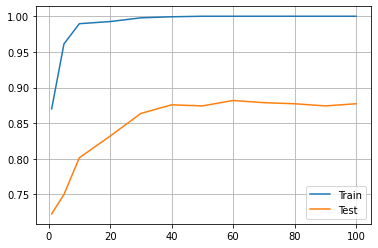

In [ ]:
plt.plot(n_estimators, scores_train, label='Train')
plt.plot(n_estimators, scores_test, label='Test')

plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
# Зависимость качества от числа признаков при расщеплении

models = []
scores_train = []
scores_test = []
max_features = list(range(1, 13))
for features in max_features:
    model = RandomForestClassifier(random_state=123, class_weight='balanced', criterion='gini', 
                                     max_depth=10, max_features=features,
                                     n_estimators=100)
    model.fit(X_train, y_train)
    models.append(model)
    scores_test.append(model.score(X_test, y_test))
    scores_train.append(model.score(X_train, y_train))

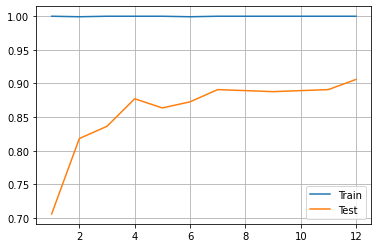

In [ ]:
plt.plot(max_features, scores_train, label='Train')
plt.plot(max_features, scores_test, label='Test')

plt.legend(loc='Best')
plt.grid()
plt.show()

In [ ]:
# Зависимость результата от глубины деревьев

models = []
scores_train = []
scores_test = []
current_depth = []
max_depth = list(range(1, 11))
for depth in max_depth:
    model = RandomForestClassifier(random_state=123, class_weight='balanced', criterion='gini', 
                                     max_depth=depth, max_features=13,
                                     n_estimators=100)
    model.fit(X_train, y_train)
    models.append(model)
    scores_test.append(model.score(X_test, y_test))
    scores_train.append(model.score(X_train, y_train))
    current_depth.append(model.estimators_[0].get_depth()/depth)

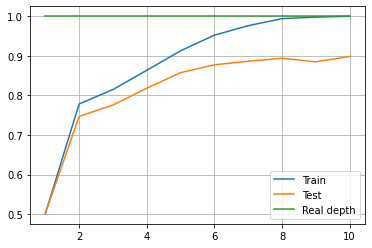

In [ ]:
plt.plot(max_depth, scores_train, label='Train')
plt.plot(max_depth, scores_test, label='Test')
plt.plot(max_depth, current_depth, label='Real depth')

plt.legend(loc='Best')
plt.grid()
plt.show()

# Линейные методы

## SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[0.001, 0.01, 0.1, 1.]}
svc = SVC(random_state=123)
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(X_train, y_train)

pprint(sorted(clf.cv_results_.keys()))
best_params = clf.best_params_
pprint(best_params)

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']
{'C': 0.001, 'kernel': 'linear'}


In [ ]:
model = SVC(random_state=123).set_params(**best_params)
model.fit(X_train, y_train)
print("Train f1-score - ", f1_score(model.predict(X_train), y_train, average='macro'), " Test f1-score - ",  
      f1_score(model.predict(X_test), y_test, average='macro'))

Train f1-score -  0.9821039324231535  Test f1-score -  0.9788319493966546


#Вероятностные методы

##Наивный байесовский классификатор

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB

In [ ]:
parameters = {'alpha': [0.1, 0.3, 0.5, 0.7, 1.0, 0.05]}
nb = MultinomialNB()
clf = GridSearchCV(nb, parameters, cv=5)
clf.fit(X_train, y_train)

pprint(clf.best_score_)

0.5014925373134329


In [ ]:
parameters = {'alpha': [0.1, 0.3, 0.5, 0.7, 1.0, 0.05]}
nb = ComplementNB()
clf = GridSearchCV(nb, parameters, cv=5)
clf.fit(X_train, y_train)

pprint(clf.best_score_)

0.4708955223880597


In [ ]:
parameters = {'var_smoothing': [1e-9, 1e-10, 1e-7, 1e-6, 1e-5, 1e-4]}
nb = GaussianNB()
clf = GridSearchCV(nb, parameters, cv=5)
clf.fit(X_train, y_train)

pprint(sorted(clf.cv_results_.keys()))
best_params = clf.best_params_
pprint(best_params)
pprint(clf.best_score_)

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_var_smoothing',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']
{'var_smoothing': 1e-05}
0.8059701492537314


In [ ]:
model = GaussianNB().set_params(**best_params)
model.fit(X_train, y_train)
print("Train f1-score - ", f1_score(model.predict(X_train), y_train, average='macro'), " Test f1-score - ",  
      f1_score(model.predict(X_test), y_test, average='macro'))

Train f1-score -  0.8121937567359023  Test f1-score -  0.7898273204878166


---


#Заключение

Выводы о качестве классификации принимались на основе значения метрики F1.

F1 = 2 * (precision * recall) / (precision + recall)

Эта метрика хорошо отражает качество классификации т.к. обращает внимание на качество предсказания для каждого отдельного класса. Оценка F1 может быть интерпретирована как среднее гармоническое значение точности и полноты. 
Эта метрика более предпочтительна, чем accuracy.

---

###1. Метод "К ближайших соседей (KNN)"

* Лучшее количество соседей: 9
* Качество на обучении: 0.94
* Качество на тесте: 0.93
* При числе соседей равном 9, получается наибольший f1_score на test-выборке, и второй по величине на train-выборке.

###2. Метод "Радиус ближайших соседей (RNN)"

* Лучший радиус: 519
* Качество на обучении: 0.94
* Качество на тесте:  0.93
* При радиусе равном 519, получается наибольший f1_score на test-выборке, и второй по величине на train-выборке.

###3. Метод "Окно Парзена-Розенблатта"

* Лучшая ширина: 200
* Качество на обучении: 0.97
* Качество на тесте: 0.94
* При ширине равной 200, получается наибольший f1_score на test-выборке и на train-выборке.

###4. Решающее дерево
* Criterion - entropy
* max_depth - 9
* Качество на обучении: 0.97
* Качество на тесте: 0.86
* При таких параметрах получается лучший f1_score на test-выборке и второй по величине на train-выборке

###5. Случайный лес
* Criterion - gini
* max_depth - 10
* max_features - 13
* n_estimators - 100
* Качество на обучении: 1.0
* Качество на тесте: 0.9
* При таких параметрах получается лучший f1_score на test-выборке и лучший на train-выборке

###6. SVM
* C - 0.001
* kernel - linear
* Качество на обучении: 0.982
* Качество на тесте: 0.979
* При таких параметрах получается лучший f1_score при cross-validation

###7. Gaussian Naive Bayes Classifier
* var_smoothing - 1e-5
* Качество на обучении: 0.81
* Качество на тесте: 0.79
* При таких параметрах получается лучший f1_score при cross-validation
---

Лучшим методом для классификации данных, представленных в этом ноутбуке, является SVM